In [58]:
import os
import pandas as pd
import requests
from tqdm import tqdm

# 加载数据集
data_path = 'datasets.xlsx'
df = pd.read_excel(data_path)

# 确保有保存图片的目录
image_save_dir = 'gas_stove_images'
os.makedirs(image_save_dir, exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# # 下载图片
# for idx, url in tqdm(enumerate(df['煤气灶图片地址']), total=len(df)):
#     try:
#         response = requests.get(url, timeout=10)
#         response.raise_for_status()  # 确保请求成功
#         # 保存图片
#         with open(os.path.join(image_save_dir, f'image_{idx}.jpg'), 'wb') as f:
#             f.write(response.content)
#     except Exception as e:
#         print(f"Error downloading image {idx}: {e}")

In [82]:
df.shape

(8058, 18)

In [60]:
df = df.dropna(subset=['煤气灶图片地址'])

In [61]:
df.shape

(7463, 18)

In [91]:
df = df[:2000]

In [92]:
df['是否合格.2'].value_counts()

是否合格.2
不合格    1784
合格      216
Name: count, dtype: int64

In [ ]:
from sklearn.utils import resample
from PIL import Image

def is_image_valid(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify that it's a valid image
        return True
    except (OSError, IOError):
        return False
    
valid_indices = [i for i in range(len(df)) if is_image_valid(os.path.join(image_save_dir, f'image_{i}.jpg')) == False]
df = df.iloc[valid_indices]
# Separate majority and minority classes
df_majority = df[df['是否合格.2'] == '不合格']
df_minority = df[df['是否合格.2'] == '合格']

# Oversample the minority class
df_minority_oversampled = resample(df_minority, 
                                   replace=True,  # Sample with replacement
                                   n_samples=len(df_majority),  # Match majority class size
                                   random_state=42)

# Combine majority and oversampled minority
df_balanced = pd.concat([df_majority, df_minority_oversampled])

In [93]:
invalid_indices = [i for i in range(len(df)) if is_image_valid(os.path.join(image_save_dir, f'image_{i}.jpg')) == False]


In [84]:
valid_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [85]:
df_balanced['不合格原因.2'].unique()

array(['被挡住无法看出', '无熄火保护装置', '猛火灶', '模糊无法看出', nan], dtype=object)

In [86]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 自定义数据集
class GasStoveDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f'image_{idx}.jpg')
        image = Image.open(image_path).convert("RGB")

        # 标签处理：一级标签（是否合格）
        label_1 = 1 if self.df.iloc[idx]['是否合格.2'] == '合格' else 0
        # 二级标签（不合格原因）
        reason = self.df.iloc[idx]['不合格原因.2']
        if reason == '被挡住无法看出':
            label_2 = 0
        elif reason == '无熄火保护装置':
            label_2 = 1
        elif reason == '猛火灶':
            label_2 = 2
        elif reason == '模糊无法看出':
            label_2 = 3
        else:
            label_2 = -1  # Default case if reason is not recognized

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_1, dtype=torch.float), torch.tensor(label_2, dtype=torch.long)

# 图像增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_val_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42)  # 80% train+val, 20% test
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)  # 80% train, 20% val

# Print dataset sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 4016
Validation size: 1004
Test size: 1256


In [87]:
# Create datasets
train_dataset = GasStoveDataset(train_df, image_save_dir, transform=transform)
val_dataset = GasStoveDataset(val_df, image_save_dir, transform=transform)
test_dataset = GasStoveDataset(test_df, image_save_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

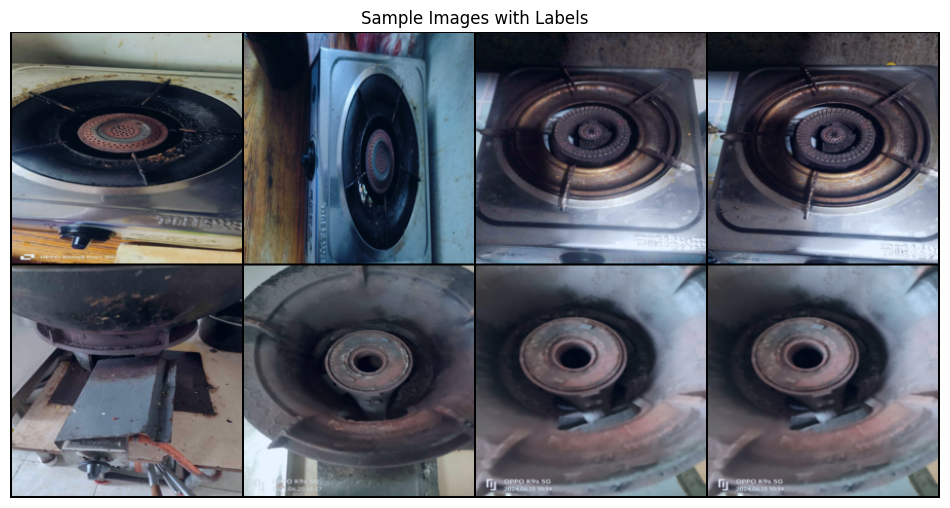

Image 1: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 0
Image 2: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = -1
Image 3: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 3
Image 4: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 0
Image 5: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 0
Image 6: Label 1 (合格/不合格) = 0.0, Label 2 (Reason) = 1
Image 7: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = -1
Image 8: Label 1 (合格/不合格) = 1.0, Label 2 (Reason) = -1


In [88]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(dataset, num_images=8):
    """
    Display a grid of images from the dataset.
    Args:
        dataset: The dataset object (e.g., train_dataset, val_dataset).
        num_images: Number of images to display.
    """
    # Get a batch of images and labels
    images, labels_1, labels_2 = zip(*[dataset[i] for i in range(num_images)])

    # Convert tensor to grid
    images = torch.stack(images)  # Combine tensors
    grid = make_grid(images, nrow=4, normalize=True, scale_each=True)

    # Plot the grid
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Permute to HWC for matplotlib
    plt.axis("off")
    plt.title("Sample Images with Labels")
    plt.show()

    # Display labels
    for i in range(num_images):
        print(f"Image {i+1}: Label 1 (合格/不合格) = {labels_1[i].item()}, Label 2 (Reason) = {labels_2[i].item()}")

# Example usage
show_images(train_dataset)

In [89]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

# 定义模型
class GasStoveClassifier(nn.Module):
    def __init__(self, num_classes_reason=2):
        super(GasStoveClassifier, self).__init__()
        self.feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) # weights=ResNet50_Weights.IMAGENET1K_V1  weights=ResNet50_Weights.DEFAULT
        self.feature_extractor.fc = nn.Identity()  # 移除最后一层
        
        self.classifier_1 = nn.Linear(2048, 1)  # 一级分类器
        self.classifier_2 = nn.Linear(2048, num_classes_reason)  # 二级分类器

    def forward(self, x):
        features = self.feature_extractor(x)
        output_1 = torch.sigmoid(self.classifier_1(features))  # 合格/不合格
        output_2 = self.classifier_2(features)  # 不合格原因
        return output_1, output_2

# 初始化模型
model = GasStoveClassifier()
model = model.cuda()  # 使用 GPU 加速

# 损失函数和优化器
criterion_1 = nn.BCELoss()  # 一级分类损失
criterion_2 = nn.CrossEntropyLoss()  # 二级分类损失
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
# Training loop with validation
epochs = 10
best_val_loss = float('inf')  # Track the best validation loss for model saving
# Function to compute metrics
def compute_metrics(predictions, labels, threshold=0.5):
    preds = (predictions > threshold).float().cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)
    return precision, recall, f1, accuracy

# Training loop with metrics
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

    for images, label_1, label_2 in train_loader:
        images = images.cuda()
        label_1 = label_1.cuda().unsqueeze(1)
        label_2 = label_2.cuda()

        optimizer.zero_grad()

        # Forward pass
        output_1, output_2 = model(images)
        loss_1 = criterion_1(output_1, label_1)
        loss_2 = criterion_2(output_2, label_2)

        mask = (label_1 == 0).float()
        loss = loss_1 + (loss_2 * mask).mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute metrics for Level 1 (合格/不合格)
        precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
        train_metrics["precision"].append(precision)
        train_metrics["recall"].append(recall)
        train_metrics["f1"].append(f1)
        train_metrics["accuracy"].append(accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

    with torch.no_grad():
        for images, label_1, label_2 in val_loader:
            images = images.cuda()
            label_1 = label_1.cuda().unsqueeze(1)
            label_2 = label_2.cuda()

            output_1, output_2 = model(images)
            loss_1 = criterion_1(output_1, label_1)
            loss_2 = criterion_2(output_2, label_2)

            mask = (label_1 == 0).float()
            loss = loss_1 + (loss_2 * mask).mean()

            val_loss += loss.item()

            # Compute metrics for Level 1 (合格/不合格)
            precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
            val_metrics["precision"].append(precision)
            val_metrics["recall"].append(recall)
            val_metrics["f1"].append(f1)
            val_metrics["accuracy"].append(accuracy)

    # Aggregate metrics
    avg_train_metrics = {k: sum(v)/len(v) for k, v in train_metrics.items()}
    avg_val_metrics = {k: sum(v)/len(v) for k, v in val_metrics.items()}

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Train Metrics: Precision: {avg_train_metrics['precision']:.4f}, Recall: {avg_train_metrics['recall']:.4f}, F1: {avg_train_metrics['f1']:.4f}, Accuracy: {avg_train_metrics['accuracy']:.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    print(f"Val Metrics: Precision: {avg_val_metrics['precision']:.4f}, Recall: {avg_val_metrics['recall']:.4f}, F1: {avg_val_metrics['f1']:.4f}, Accuracy: {avg_val_metrics['accuracy']:.4f}")

    # Save best model based on validation F1 score
    if avg_val_metrics["f1"] > best_val_loss:
        best_val_loss = avg_val_metrics["f1"]
        torch.save(model.state_dict(), "best_gas_stove_model.pth")
        print("Saved Best Model!")

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [10,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_gas_stove_model.pth"))

# Test evaluation with metrics
model.eval()
test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
conf_matrix = None

with torch.no_grad():
    for images, label_1, label_2 in test_loader:
        images = images.cuda()
        label_1 = label_1.cuda().unsqueeze(1)
        label_2 = label_2.cuda()

        output_1, output_2 = model(images)
        precision, recall, f1, accuracy = compute_metrics(output_1, label_1)

        test_metrics["precision"].append(precision)
        test_metrics["recall"].append(recall)
        test_metrics["f1"].append(f1)
        test_metrics["accuracy"].append(accuracy)

        # Compute confusion matrix
        preds = (output_1 > 0.5).float().cpu().numpy()
        labels = label_1.cpu().numpy()
        if conf_matrix is None:
            conf_matrix = confusion_matrix(labels, preds)
        else:
            conf_matrix += confusion_matrix(labels, preds)

# Aggregate test metrics
avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
print(f"Test Metrics: Precision: {avg_test_metrics['precision']:.4f}, Recall: {avg_test_metrics['recall']:.4f}, F1: {avg_test_metrics['f1']:.4f}, Accuracy: {avg_test_metrics['accuracy']:.4f}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

/tmp/ipykernel_1585001/2406125399.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gas_stove_model.pth"))


/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

Test Metrics: Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Accuracy: 1.0000
Confusion Matrix:
[[20]]


/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kz34/Yang_Ouyang_Projects/nemo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm

# 加载数据集
data_path = 'datasets.xlsx'
df = pd.read_excel(data_path)

# 确保有保存图片的目录
image_save_dir = 'gas_stove_images'
os.makedirs(image_save_dir, exist_ok=True)

# 下载图片
for idx, url in tqdm(enumerate(df['煤气灶图片地址']), total=len(df)):
    if idx != 1172:
        continue
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # 确保请求成功
        # 保存图片
        with open(os.path.join(image_save_dir, f'image_{idx}.jpg'), 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f"Error downloading image {idx}: {e}")

100%|██████████| 8058/8058 [00:00<00:00, 2884501.29it/s]

Error downloading image 1172: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?


[INFO] Script started.
[INFO] Starting data loading and preprocessing...
[INFO] Valid images after enhanced validation: 7463
[INFO] Label distribution before balancing:
是否合格.2 分布:
是否合格.2
不合格    5943
合格     1518
Name: count, dtype: int64
不合格原因.2 分布 (仅不合格样本):
不合格原因.2
无熄火保护装置    3233
被挡住无法看出    2538
模糊无法看出      150
猛火灶          20
Name: count, dtype: int64
[INFO] Balanced dataset size: 11886
Balanced Label 1 distribution:
是否合格.2
不合格    5943
合格     5943
Name: count, dtype: int64
[WARNING] Found 2 '不合格' samples with missing '不合格原因.2':
      original_index 燃气用户名称 用户类型  \
3277            3926    李春花   居民   
5106            6364    张孝妹   居民   

                                                 门窗图片地址  Unnamed: 3 是否合格  \
3277  http://jsxk-household-inspection.oss-cn-hangzh...         NaN   合格   
5106                                                NaN         NaN  NaN   

     不合格原因                                            调压器图片地址  Unnamed: 7  \
3277   NaN  http://jsxk-household-inspection.oss-

/tmp/ipykernel_2795183/3925479810.py:599: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path[0])


[INFO] Loaded best model from best_gas_stove_model_20241128_132527.pth
[INFO] Starting evaluation on test set...



[Test Results]
Precision: 0.9549
Recall: 0.9862
F1 Score: 0.9676
Accuracy: 0.9690
Confusion Matrix:
[[568  26]
 [  9 586]]
[INFO] Evaluation on test set completed.


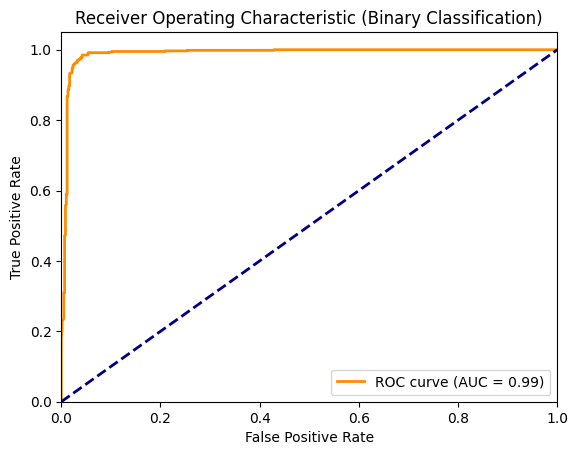

[INFO] Script finished.


In [1]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.utils import resample
from PIL import Image, ImageFile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from datetime import datetime


# 允许加载截断的图像（可选，根据需要使用）
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 设置CUDA设备
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # 根据您的环境调整
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess_data(data_path, image_save_dir):
    """
    加载数据集，验证图像完整性，过滤无效样本，并进行数据平衡。
    
    Args:
        data_path (str): 数据集Excel文件路径。
        image_save_dir (str): 图像保存目录路径。
    
    Returns:
        pd.DataFrame: 经过验证和平衡后的数据集。
    """
    print("[INFO] Starting data loading and preprocessing...")
    # 加载数据集
    df = pd.read_excel(data_path)
    df = df.dropna(subset=['煤气灶图片地址'])  # 确保图像地址不为NaN
    
    # 添加原始索引作为新的列
    df = df.reset_index().rename(columns={'index': 'original_index'})
    
    # 确保有保存图片的目录
    os.makedirs(image_save_dir, exist_ok=True)
    
    def is_image_valid(image_path):
        try:
            with Image.open(image_path) as img:
                img.load()  # 完全加载图像数据以确保其完整性
            return True
        except (OSError, IOError) as e:
            print(f"[WARNING] Image validation failed for {image_path}: {e}")
            return False
    
    # 过滤出有效的图片，保留原始索引
    df_valid = df[df['original_index'].apply(
        lambda x: is_image_valid(os.path.join(image_save_dir, f'image_{x}.jpg'))
    )].reset_index(drop=True)
    
    print(f"[INFO] Valid images after enhanced validation: {len(df_valid)}")
    
    # 打印标签分布
    print("[INFO] Label distribution before balancing:")
    print("是否合格.2 分布:")
    print(df_valid['是否合格.2'].value_counts())
    print("不合格原因.2 分布 (仅不合格样本):")
    print(df_valid[df_valid['是否合格.2'] == '不合格']['不合格原因.2'].value_counts())
    
    # 数据平衡：过采样少数类
    df_majority = df_valid[df_valid['是否合格.2'] == '不合格']
    df_minority = df_valid[df_valid['是否合格.2'] == '合格']
    
    df_minority_oversampled = resample(
        df_minority, 
        replace=True,  # 允许重复采样
        n_samples=len(df_majority),  # 使少数类数量与多数类相同
        random_state=42
    )
    
    # 组合多数类和过采样的少数类
    df_balanced = pd.concat([df_majority, df_minority_oversampled]).reset_index(drop=True)
    print(f"[INFO] Balanced dataset size: {len(df_balanced)}")
    print("Balanced Label 1 distribution:")
    print(df_balanced['是否合格.2'].value_counts())
    
    # 处理“不合格”样本中 '不合格原因.2' 为 nan 的情况
    invalid_unqualified = df_balanced[
        (df_balanced['是否合格.2'] == '不合格') & 
        (df_balanced['不合格原因.2'].isna())
    ]
    
    if not invalid_unqualified.empty:
        print(f"[WARNING] Found {len(invalid_unqualified)} '不合格' samples with missing '不合格原因.2':")
        print(invalid_unqualified)
        # 移除这些无效样本
        df_balanced = df_balanced.drop(invalid_unqualified.index).reset_index(drop=True)
        print(f"[INFO] Balanced dataset size after removing invalid '不合格' samples: {len(df_balanced)}")
    else:
        print("[INFO] All '不合格' samples have valid '不合格原因.2'.")
    
    print("[INFO] Data loading and preprocessing completed.")
    return df_balanced

class GasStoveDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, debug=False):
        """
        自定义数据集类。
        
        Args:
            df (pd.DataFrame): 数据集DataFrame。
            image_dir (str): 图像保存目录路径。
            transform (callable, optional): 图像转换函数。
            debug (bool, optional): 是否启用调试打印。
        """
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.debug = debug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        original_index = self.df.iloc[idx]['original_index']
        image_path = os.path.join(self.image_dir, f'image_{original_index}.jpg')
        
        try:
            with Image.open(image_path) as img:
                image = img.convert("RGB")
                if self.transform:
                    image = self.transform(image)
        except (OSError, IOError) as e:
            print(f"[WARNING] Error loading image {image_path}: {e}")
            # 返回一个全黑图像作为占位符
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            if self.transform:
                image = self.transform(image)

        # Label 1: 合格/不合格
        label_1 = 1 if self.df.iloc[idx]['是否合格.2'] == '合格' else 0

        # Label 2: 不合格原因
        reason = self.df.iloc[idx]['不合格原因.2']
        if label_1 == 1:
            label_2 = 4  # 无不合格原因
        else:
            if pd.isna(reason):
                print(f"[WARNING] '不合格原因.2' is NaN for index {idx}. Assigning label_2 as 4 ('未知').")
                label_2 = 4  # 或者您可以选择一个新的标签
            else:
                if reason == '被挡住无法看出':
                    label_2 = 0
                elif reason == '无熄火保护装置':
                    label_2 = 1
                elif reason == '猛火灶':
                    label_2 = 2
                elif reason == '模糊无法看出':
                    label_2 = 3
                else:
                    raise ValueError(f"Unrecognized reason '{reason}' at index {idx}")

        # 调试打印
        if self.debug and idx < 5:  # 仅打印前5个样本
            if label_1 == 1:
                print(f"[DEBUG] Index {idx}: 合格, label_2 set to 4 (无不合格原因)")
            else:
                print(f"[DEBUG] Index {idx}: 不合格, 原因: {reason}, label_2 set to {label_2}")

        return image, torch.tensor(label_1, dtype=torch.float), torch.tensor(label_2, dtype=torch.long)

def create_dataloaders(df, image_save_dir, transform, batch_size=16, num_workers=0):
    """
    划分数据集并创建DataLoader。
    
    Args:
        df (pd.DataFrame): 数据集DataFrame。
        image_save_dir (str): 图像保存目录路径。
        transform (callable): 图像转换函数。
        batch_size (int, optional): 批次大小。
        num_workers (int, optional): DataLoader的工作线程数。
    
    Returns:
        tuple: 训练集、验证集和测试集的DataLoader。
    """
    print("[INFO] Starting to create DataLoaders...")
    # 划分数据集
    train_val_df, test_df = train_test_split(
        df, 
        test_size=0.1, 
        random_state=42, 
        stratify=df['是否合格.2']
    )
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_val_df['是否合格.2']
    )

    # 打印数据集大小
    print(f"[INFO] Train size: {len(train_df)}")
    print(f"[INFO] Validation size: {len(val_df)}")
    print(f"[INFO] Test size: {len(test_df)}")

    # 打印标签分布
    print("[INFO] Train Label 1 distribution:")
    print(train_df['是否合格.2'].value_counts())
    print("[INFO] Validation Label 1 distribution:")
    print(val_df['是否合格.2'].value_counts())
    print("[INFO] Test Label 1 distribution:")
    print(test_df['是否合格.2'].value_counts())

    # 创建数据集
    train_dataset = GasStoveDataset(train_df, image_save_dir, transform=transform, debug=True)
    val_dataset = GasStoveDataset(val_df, image_save_dir, transform=transform, debug=False)
    test_dataset = GasStoveDataset(test_df, image_save_dir, transform=transform, debug=False)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("[INFO] DataLoaders created successfully.")
    return train_loader, val_loader, test_loader

def define_model(num_classes_reason=5):
    """
    定义并返回GasStoveClassifier模型。
    
    Args:
        num_classes_reason (int, optional): 不合格原因的类别数。
    
    Returns:
        nn.Module: 定义好的模型。
    """
    print("[INFO] Starting model definition...")
    class GasStoveClassifier(nn.Module):
        def __init__(self, num_classes_reason=5):
            super(GasStoveClassifier, self).__init__()
            self.feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            self.feature_extractor.fc = nn.Identity()  # 移除最后一层
            
            self.classifier_1 = nn.Linear(2048, 1)  # Binary classifier for 合格/不合格
            self.classifier_2 = nn.Linear(2048, num_classes_reason)  # Multi-class classifier for 不合格原因

        def forward(self, x):
            features = self.feature_extractor(x)
            output_1 = torch.sigmoid(self.classifier_1(features))  # Binary output
            output_2 = self.classifier_2(features)  # Multi-class output
            return output_1, output_2
    
    model = GasStoveClassifier(num_classes_reason=num_classes_reason)
    print("[INFO] Model definition completed.")
    return model

def compute_metrics(predictions, labels, threshold=0.5):
    """
    计算分类指标。
    
    Args:
        predictions (torch.Tensor): 模型的预测输出。
        labels (torch.Tensor): 真实标签。
        threshold (float, optional): 阈值，用于二分类。
    
    Returns:
        tuple: 精确度、召回率、F1分数和准确率。
    """
    preds = (predictions > threshold).float().cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    accuracy = accuracy_score(labels, preds)
    return precision, recall, f1, accuracy

def get_timestamp():
    """
    获取当前时间的字符串表示，格式为 YYYYMMDD_HHMMSS。
    
    Returns:
        str: 当前时间的字符串表示。
    """
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def train_model(model, train_loader, val_loader, criterion_1, criterion_2, optimizer, epochs, device):
    """
    训练模型。
    
    Args:
        model (nn.Module): 要训练的模型。
        train_loader (DataLoader): 训练集的DataLoader。
        val_loader (DataLoader): 验证集的DataLoader。
        criterion_1 (nn.Module): 一级分类的损失函数。
        criterion_2 (nn.Module): 二级分类的损失函数。
        optimizer (torch.optim.Optimizer): 优化器。
        epochs (int): 训练的轮数。
        device (torch.device): 训练设备。
    
    Returns:
        None
    """
    print("[INFO] Starting training...")
    best_val_f1 = 0.0  # 跟踪最佳验证F1分数以保存模型

    for epoch in range(epochs):
        epoch_start_time = datetime.now()
        print(f"\n[INFO] Epoch {epoch+1}/{epochs} started at {epoch_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

        model.train()
        train_loss = 0.0
        train_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

        # 使用 tqdm 包装训练数据加载器
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)
        for batch_idx, (images, label_1, label_2) in enumerate(train_loop):
            # 调试：仅在前几个epoch和batch中打印标签
            if epoch < 1 and batch_idx < 1:
                print(f"[DEBUG] Epoch {epoch+1}, Batch {batch_idx+1}")
                print(f"[DEBUG] Label 1: {label_1.cpu().numpy()}")
                print(f"[DEBUG] Label 2: {label_2.cpu().numpy()}")

            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            optimizer.zero_grad()

            # 前向传播
            output_1, output_2 = model(images)
            loss_1 = criterion_1(output_1, label_1)
            loss_2 = criterion_2(output_2, label_2)

            # 计算总损失
            loss = loss_1 + loss_2  # CrossEntropyLoss 已经忽略 label_2=4 的样本

            # 反向传播
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 计算指标
            precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
            train_metrics["precision"].append(precision)
            train_metrics["recall"].append(recall)
            train_metrics["f1"].append(f1)
            train_metrics["accuracy"].append(accuracy)

            # 更新 tqdm 描述
            train_loop.set_postfix(loss=loss.item(), f1=f1)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

        # 使用 tqdm 包装验证数据加载器
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, label_1, label_2 in val_loop:
                images = images.to(device)
                label_1 = label_1.to(device).unsqueeze(1)
                label_2 = label_2.to(device)

                output_1, output_2 = model(images)
                loss_1 = criterion_1(output_1, label_1)
                loss_2 = criterion_2(output_2, label_2)

                loss = loss_1 + loss_2

                val_loss += loss.item()

                # 计算指标
                precision, recall, f1, accuracy = compute_metrics(output_1, label_1)
                val_metrics["precision"].append(precision)
                val_metrics["recall"].append(recall)
                val_metrics["f1"].append(f1)
                val_metrics["accuracy"].append(accuracy)

                # 更新 tqdm 描述
                val_loop.set_postfix(loss=loss.item(), f1=f1)

        # 聚合指标
        avg_train_metrics = {k: sum(v)/len(v) for k, v in train_metrics.items()}
        avg_val_metrics = {k: sum(v)/len(v) for k, v in val_metrics.items()}

        epoch_end_time = datetime.now()
        print(f"[INFO] Epoch {epoch+1}/{epochs} ended at {epoch_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"[INFO] Duration: {epoch_end_time - epoch_start_time}")

        print(f"\n[INFO] Epoch {epoch+1}/{epochs} Summary:")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Train Metrics: Precision: {avg_train_metrics['precision']:.4f}, Recall: {avg_train_metrics['recall']:.4f}, F1: {avg_train_metrics['f1']:.4f}, Accuracy: {avg_train_metrics['accuracy']:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Metrics: Precision: {avg_val_metrics['precision']:.4f}, Recall: {avg_val_metrics['recall']:.4f}, F1: {avg_val_metrics['f1']:.4f}, Accuracy: {avg_val_metrics['accuracy']:.4f}")

        # 保存最佳模型
        if avg_val_metrics["f1"] > best_val_f1:
            best_val_f1 = avg_val_metrics["f1"]
            timestamp = get_timestamp()
            model_filename = f"best_gas_stove_model_{timestamp}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_f1': best_val_f1,
            }, model_filename)
            print(f"[INFO] Saved Best Model: {model_filename}")
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, test_loader, compute_metrics_fn, device):
    """
    Evaluate the model on the test set, compute performance metrics, and plot ROC AUC curve.
    
    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test set DataLoader.
        compute_metrics_fn (callable): Function to compute precision, recall, f1, accuracy.
        device (torch.device): Device for evaluation (cpu or cuda).
    """
    print("[INFO] Starting evaluation on test set...")
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    all_labels = []
    all_scores = []

    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for images, label_1, label_2 in test_loop:
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            # output_1 is the binary classification output (after sigmoid)
            output_1, output_2 = model(images)
            
            # Append scores and labels for ROC AUC calculation
            # output_1 is the predicted probability for the positive class
            all_scores.extend(output_1.cpu().numpy().flatten().tolist())
            all_labels.extend(label_1.cpu().numpy().flatten().tolist())

            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)
            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            # Compute confusion matrix
            preds = (output_1 > 0.5).float().cpu().numpy()
            labels = label_1.cpu().numpy()
            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels, preds)
            else:
                conf_matrix += confusion_matrix(labels, preds)

    # Aggregate test metrics
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print("\n[Test Results]")
    print(f"Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Recall: {avg_test_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_test_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("[INFO] Evaluation on test set completed.")

    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()

def show_images(dataset, num_images=8):
    """
    显示数据集中的图像网格。
    
    Args:
        dataset (Dataset): 数据集对象（例如，train_dataset, val_dataset）。
        num_images (int, optional): 显示的图像数量。
    
    Returns:
        None
    """
    print("[INFO] Displaying sample images...")
    # 获取一批图像和标签
    images, labels_1, labels_2 = zip(*[dataset[i] for i in range(num_images)])

    # 转换为网格
    images = torch.stack(images)  # 组合张量
    grid = make_grid(images, nrow=4, normalize=True, scale_each=True)

    # 绘制网格
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # 转换为HWC格式用于matplotlib
    plt.axis("off")
    plt.title("Sample Images with Labels")
    plt.show()

    # 显示标签
    for i in range(num_images):
        print(f"Image {i+1}: Label 1 (合格/不合格) = {labels_1[i].item()}, Label 2 (Reason) = {labels_2[i].item()}")
    print("[INFO] Sample images displayed.")

def inspect_sample(df, index, image_save_dir):
    """
    检查特定索引的样本详细信息。
    
    Args:
        df (pd.DataFrame): 数据集DataFrame。
        index (int): 要检查的样本索引。
        image_save_dir (str): 图像保存目录路径。
    
    Returns:
        None
    """
    print(f"[INFO] Inspecting sample at index {index}...")
    if index < 0 or index >= len(df):
        print(f"[ERROR] Index {index} is out of bounds for the DataFrame.")
        return

    sample = df.iloc[index]
    print(f"Sample at index {index}:")
    print(sample)

    # 显示图像
    original_index = sample['original_index']
    image_path = os.path.join(image_save_dir, f'image_{original_index}.jpg')
    try:
        with Image.open(image_path) as img:
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.title(f"Image at index {index}")
            plt.axis('off')
            plt.show()
    except (OSError, IOError) as e:
        print(f"[ERROR] Error loading image {image_path}: {e}")
    print(f"[INFO] Inspection of sample at index {index} completed.")

def main():
    """
    主流程函数。
    """
    print("[INFO] Script started.")

    # 数据路径和图像保存目录
    data_path = 'datasets.xlsx'
    image_save_dir = 'gas_stove_images'

    # 加载和预处理数据
    df_balanced = load_and_preprocess_data(data_path, image_save_dir)

    # 图像转换
    print("[INFO] Defining image transformations...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    print("[INFO] Image transformations defined.")

    # 创建DataLoader
    _, _, test_loader = create_dataloaders(
        df_balanced, 
        image_save_dir, 
        transform, 
        batch_size=16, 
        num_workers=0
    )

    # 定义模型
    model = define_model(num_classes_reason=5)
    model = model.to(device)


    # 加载最佳模型
    print("[INFO] Loading the best model...")
    best_model_path = sorted(
        [f for f in os.listdir('.') if f.startswith("best_gas_stove_model") and f.endswith(".pth")],
        reverse=True
    )
    if best_model_path:
        checkpoint = torch.load(best_model_path[0])
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"[INFO] Loaded best model from {best_model_path[0]}")
    else:
        print("[WARNING] No saved model found. Proceeding with the current model state.")

    # 在测试集上评估模型
    evaluate_model(model, test_loader, compute_metrics, device)

    print("[INFO] Script finished.")

if __name__ == "__main__":
    main()

In [ ]:
from sklearn.metrics import roc_curve, auc


def define_model(num_classes_reason=5):
    """
    定义并返回GasStoveClassifier模型。
    """
    print("[INFO] Starting model definition...")
    class GasStoveClassifier(nn.Module):
        def __init__(self, num_classes_reason=5):
            super(GasStoveClassifier, self).__init__()
            self.feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            self.feature_extractor.fc = nn.Identity()  # 移除最后一层
            
            self.classifier_1 = nn.Linear(2048, 1)  # Binary classifier for 合格/不合格
            self.classifier_2 = nn.Linear(2048, num_classes_reason)  # Multi-class classifier for 不合格原因

        def forward(self, x):
            features = self.feature_extractor(x)
            logits_1 = self.classifier_1(features)  # 原始logit输出
            output_1 = torch.sigmoid(logits_1)       # 概率输出
            output_2 = self.classifier_2(features)    # Multi-class output
            # 返回logits_1是为了能打印原始预测值
            return logits_1, output_1, output_2
    
    model = GasStoveClassifier(num_classes_reason=num_classes_reason)
    print("[INFO] Model definition completed.")
    return model

def evaluate_model(model, test_loader, compute_metrics_fn, device):
    """
    Evaluate the model on the test set, compute performance metrics, and print/plot predictions.
    """
    print("[INFO] Starting evaluation on test set...")
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    all_labels = []
    all_scores = []

    # 用来存储和打印每条数据的预测logit, 概率和真实标签
    sample_predictions = []

    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for images, label_1, label_2 in test_loop:
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)
 
            logits_1, output_1, output_2 = model(images)

            # 保存每个样本的预测logit和概率
            # logits_1: [batch_size, 1], output_1: [batch_size, 1], label_1: [batch_size, 1]
            logits_np = logits_1.cpu().numpy().flatten()
            probs_np = output_1.cpu().numpy().flatten()
            labels_np = label_1.cpu().numpy().flatten()

            for logit_val, prob_val, true_label in zip(logits_np, probs_np, labels_np):
                sample_predictions.append((logit_val, prob_val, true_label))

            # Append scores and labels for ROC AUC calculation
            all_scores.extend(output_1.cpu().numpy().flatten().tolist())
            all_labels.extend(labels_np.tolist())

            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)
            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            # Compute confusion matrix
            preds = (output_1 > 0.5).float().cpu().numpy()
            labels = label_1.cpu().numpy()
            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels, preds)
            else:
                conf_matrix += confusion_matrix(labels, preds)

    # 打印所有样本的预测情况
    print("\n[INFO] Printing predictions for each sample (logit, probability, label):")
    for i, (logit_val, prob_val, true_label) in enumerate(sample_predictions):
        print(f"Sample {i+1}: Logit={logit_val:.4f}, Probability={prob_val:.4f}, True Label={true_label}")

    # Aggregate test metrics
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print("\n[Test Results]")
    print(f"Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Recall: {avg_test_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_test_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("[INFO] Evaluation on test set completed.")

    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()
    
def evaluate_model(model, test_loader, compute_metrics_fn, device):
    """
    Evaluate the model on the test set, compute performance metrics, and print/plot predictions.
    """
    print("[INFO] Starting evaluation on test set...")
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    all_labels = []
    all_scores = []

    # 用来存储和打印每条数据的预测logit, 概率和真实标签
    sample_predictions = []

    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for images, label_1, label_2 in test_loop:
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            logits_1, output_1, output_2 = model(images)

            # 保存每个样本的预测logit和概率
            # logits_1: [batch_size, 1], output_1: [batch_size, 1], label_1: [batch_size, 1]
            logits_np = logits_1.cpu().numpy().flatten()
            probs_np = output_1.cpu().numpy().flatten()
            labels_np = label_1.cpu().numpy().flatten()

            for logit_val, prob_val, true_label in zip(logits_np, probs_np, labels_np):
                sample_predictions.append((logit_val, prob_val, true_label))

            # Append scores and labels for ROC AUC calculation
            all_scores.extend(output_1.cpu().numpy().flatten().tolist())
            all_labels.extend(labels_np.tolist())

            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)
            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            # Compute confusion matrix
            preds = (output_1 > 0.5).float().cpu().numpy()
            labels = label_1.cpu().numpy()
            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels, preds)
            else:
                conf_matrix += confusion_matrix(labels, preds)

    # 打印所有样本的预测情况
    print("\n[INFO] Printing predictions for each sample (logit, probability, label):")
    for i, (logit_val, prob_val, true_label) in enumerate(sample_predictions):
        print(f"Sample {i+1}: Logit={logit_val:.4f}, Probability={prob_val:.4f}, True Label={true_label}")

    # Aggregate test metrics
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print("\n[Test Results]")
    print(f"Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Recall: {avg_test_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_test_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("[INFO] Evaluation on test set completed.")

    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()

def show_images(dataset, num_images=8):
    """
    显示数据集中的图像网格。
    
    Args:
        dataset (Dataset): 数据集对象（例如，train_dataset, val_dataset）。
        num_images (int, optional): 显示的图像数量。
    
    Returns:
        None
    """
    print("[INFO] Displaying sample images...")
    # 获取一批图像和标签
    images, labels_1, labels_2 = zip(*[dataset[i] for i in range(num_images)])

    # 转换为网格
    images = torch.stack(images)  # 组合张量
    grid = make_grid(images, nrow=4, normalize=True, scale_each=True)

    # 绘制网格
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # 转换为HWC格式用于matplotlib
    plt.axis("off")
    plt.title("Sample Images with Labels")
    plt.show()

    # 显示标签
    for i in range(num_images):
        print(f"Image {i+1}: Label 1 (合格/不合格) = {labels_1[i].item()}, Label 2 (Reason) = {labels_2[i].item()}")
    print("[INFO] Sample images displayed.")

def inspect_sample(df, index, image_save_dir):
    """
    检查特定索引的样本详细信息。
    
    Args:
        df (pd.DataFrame): 数据集DataFrame。
        index (int): 要检查的样本索引。
        image_save_dir (str): 图像保存目录路径。
    
    Returns:
        None
    """
    print(f"[INFO] Inspecting sample at index {index}...")
    if index < 0 or index >= len(df):
        print(f"[ERROR] Index {index} is out of bounds for the DataFrame.")
        return

    sample = df.iloc[index]
    print(f"Sample at index {index}:")
    print(sample)

    # 显示图像
    original_index = sample['original_index']
    image_path = os.path.join(image_save_dir, f'image_{original_index}.jpg')
    try:
        with Image.open(image_path) as img:
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.title(f"Image at index {index}")
            plt.axis('off')
            plt.show()
    except (OSError, IOError) as e:
        print(f"[ERROR] Error loading image {image_path}: {e}")
    print(f"[INFO] Inspection of sample at index {index} completed.")

# def main():
#     """
#     主流程函数。
#     """
#     print("[INFO] Script started.")

#     # 数据路径和图像保存目录
#     data_path = 'datasets.xlsx'
#     image_save_dir = 'gas_stove_images'

#     # 加载和预处理数据
#     df_balanced = load_and_preprocess_data(data_path, image_save_dir)

#     # 图像转换
#     print("[INFO] Defining image transformations...")
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     print("[INFO] Image transformations defined.")

#     # 创建DataLoader
#     _, _, test_loader = create_dataloaders(
#         df_balanced, 
#         image_save_dir, 
#         transform, 
#         batch_size=16, 
#         num_workers=0
#     )

#     # 定义模型
#     model = define_model(num_classes_reason=5)
#     model = model.to(device)

#     # 加载最佳模型
#     print("[INFO] Loading the best model...")
#     best_model_path = sorted(
#         [f for f in os.listdir('.') if f.startswith("best_gas_stove_model") and f.endswith(".pth")],
#         reverse=True
#     )
#     if best_model_path:
#         checkpoint = torch.load(best_model_path[0])
#         model.load_state_dict(checkpoint['model_state_dict'])
#         print(f"[INFO] Loaded best model from {best_model_path[0]}")
#     else:
#         print("[WARNING] No saved model found. Proceeding with the current model state.")

#     # 在测试集上评估模型
#     evaluate_model(model, test_loader, compute_metrics, device)

#     print("[INFO] Script finished.")

# if __name__ == "__main__":
#     main()

In [ ]:

"""
主流程函数。
"""
print("[INFO] Script started.")

# 数据路径和图像保存目录
data_path = 'datasets.xlsx'
image_save_dir = 'gas_stove_images'

# 加载和预处理数据
df_balanced = load_and_preprocess_data(data_path, image_save_dir)

# 图像转换
print("[INFO] Defining image transformations...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print("[INFO] Image transformations defined.")

# 创建DataLoader
_, _, test_loader = create_dataloaders(
    df_balanced, 
    image_save_dir, 
    transform, 
    batch_size=16, 
    num_workers=0
)

# 定义模型
model = define_model(num_classes_reason=5)
model = model.to(device)

# 加载最佳模型
print("[INFO] Loading the best model...")
best_model_path = sorted(
    [f for f in os.listdir('.') if f.startswith("best_gas_stove_model") and f.endswith(".pth")],
    reverse=True
)
if best_model_path:
    checkpoint = torch.load(best_model_path[0])
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"[INFO] Loaded best model from {best_model_path[0]}")
else:
    print("[WARNING] No saved model found. Proceeding with the current model state.")

# 在测试集上评估模型
evaluate_model(model, test_loader, compute_metrics, device)

print("[INFO] Script finished.")



[INFO] Script started.
[INFO] Starting data loading and preprocessing...
[INFO] Valid images after enhanced validation: 7463
[INFO] Label distribution before balancing:
是否合格.2 分布:
是否合格.2
不合格    5943
合格     1518
Name: count, dtype: int64
不合格原因.2 分布 (仅不合格样本):
不合格原因.2
无熄火保护装置    3233
被挡住无法看出    2538
模糊无法看出      150
猛火灶          20
Name: count, dtype: int64
[INFO] Balanced dataset size: 11886
Balanced Label 1 distribution:
是否合格.2
不合格    5943
合格     5943
Name: count, dtype: int64
[WARNING] Found 2 '不合格' samples with missing '不合格原因.2':
      original_index 燃气用户名称 用户类型  \
3277            3926    李春花   居民   
5106            6364    张孝妹   居民   

                                                 门窗图片地址  Unnamed: 3 是否合格  \
3277  http://jsxk-household-inspection.oss-cn-hangzh...         NaN   合格   
5106                                                NaN         NaN  NaN   

     不合格原因                                            调压器图片地址  Unnamed: 7  \
3277   NaN  http://jsxk-household-inspection.oss-

/tmp/ipykernel_2795183/3858095417.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path[0])



[INFO] Printing predictions for each sample (logit, probability, label):
Sample 1: Logit=16.3698, Probability=1.0000, True Label=1.0
Sample 2: Logit=9.5948, Probability=0.9999, True Label=1.0
Sample 3: Logit=-7.4185, Probability=0.0006, True Label=0.0
Sample 4: Logit=16.6288, Probability=1.0000, True Label=1.0
Sample 5: Logit=-1.9966, Probability=0.1196, True Label=0.0
Sample 6: Logit=-1.3763, Probability=0.2016, True Label=0.0
Sample 7: Logit=-8.8001, Probability=0.0002, True Label=0.0
Sample 8: Logit=8.5466, Probability=0.9998, True Label=1.0
Sample 9: Logit=5.5193, Probability=0.9960, True Label=1.0
Sample 10: Logit=-13.9137, Probability=0.0000, True Label=0.0
Sample 11: Logit=-7.2365, Probability=0.0007, True Label=0.0
Sample 12: Logit=19.7305, Probability=1.0000, True Label=1.0
Sample 13: Logit=12.9035, Probability=1.0000, True Label=1.0
Sample 14: Logit=12.4786, Probability=1.0000, True Label=1.0
Sample 15: Logit=7.2348, Probability=0.9993, True Label=1.0
Sample 16: Logit=18.483

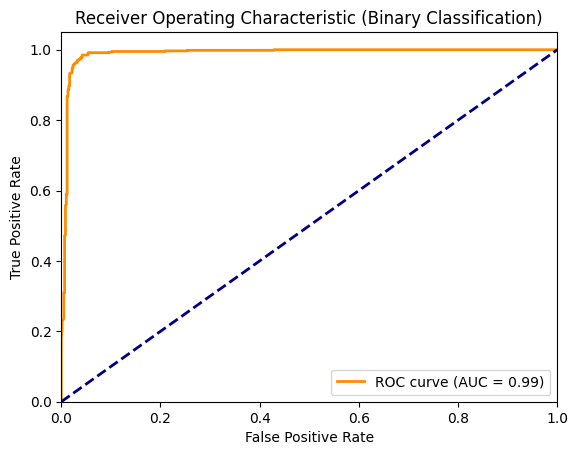

[INFO] Script finished.


In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, compute_metrics_fn, device, image_save_dir):
    """
    Evaluate the model on the test set, compute performance metrics, 
    analyze false positives, and display their images.
    """
    print("[INFO] Starting evaluation on test set...")
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    all_labels = []
    all_scores = []
    
    # 用于存储预测详情的列表，包括logit、概率、真实标签、预测标签、以及数据集索引
    sample_details = []

    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        dataset = test_loader.dataset
        for batch_idx, (images, label_1, label_2) in enumerate(test_loop):
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            batch_size = images.size(0)
            start_idx = batch_idx * test_loader.batch_size
            end_idx = start_idx + batch_size

            logits_1, output_1, output_2 = model(images)

            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)
            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            logits_np = logits_1.cpu().numpy().flatten()
            probs_np = output_1.cpu().numpy().flatten()
            labels_np = label_1.cpu().numpy().flatten()
            preds_np = (probs_np > 0.5).astype(int)

            all_scores.extend(probs_np.tolist())
            all_labels.extend(labels_np.tolist())

            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels_np, preds_np)
            else:
                conf_matrix += confusion_matrix(labels_np, preds_np)

            # 保存当前batch每个样本的详细信息
            for i in range(batch_size):
                df_idx = start_idx + i
                original_idx = dataset.df.iloc[df_idx]['original_index']
                sample_details.append({
                    'original_index': original_idx,
                    'logit': logits_np[i],
                    'prob': probs_np[i],
                    'true_label': labels_np[i],
                    'pred_label': preds_np[i]
                })

    # 计算平均指标
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print("\n[Test Results]")
    print(f"Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Recall: {avg_test_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_test_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # 打印混淆矩阵
    print("Confusion Matrix:")
    print(conf_matrix)
    print("[INFO] Evaluation on test set completed.")

    # 假阳性分析：True Label=0(不合格), Pred Label=1(合格)
    false_positives = [s for s in sample_details if s['true_label'] == 0 and s['pred_label'] == 1]

    print("\n[False Positives Analysis]")
    print(f"Number of False Positives: {len(false_positives)}")
    
    # 显示假阳性样本的图片
    # 如果假阳性样本很多，可以限制显示的数量，例如只显示前10个
 # Assuming all other imports and variable definitions are done
    num_to_show = false_positives

    for idx, fp in enumerate(false_positives[:num_to_show]):
        img_path = os.path.join(image_save_dir, f"image_{fp['original_index']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(
                f"FP #{idx+1}\nOriginal Index:{fp['original_index']}\n"
                f"Logit: {fp['logit']:.4f}, Prob: {fp['prob']:.4f}, "
                f"True:{fp['true_label']}, Pred:{fp['pred_label']}"
            )
            plt.axis('off')
            
            # Save after setting image and title
            os.makedirs("imgs", exist_ok=True)
            plt.savefig(f"imgs/fp_{idx+1}.png", dpi=300)
            plt.show()
        else:
            print(f"[WARNING] Image not found: {img_path}")

    # 计算并绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()

# # 在主流程调用时传入image_save_dir
# """
# 主流程函数。
# """
# print("[INFO] Script started.")

# data_path = 'datasets.xlsx'
# image_save_dir = 'gas_stove_images'

# df_balanced = load_and_preprocess_data(data_path, image_save_dir)

# print("[INFO] Defining image transformations...")
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# print("[INFO] Image transformations defined.")

# _, _, test_loader = create_dataloaders(
#     df_balanced, 
#     image_save_dir, 
#     transform, 
#     batch_size=16, 
#     num_workers=0
# )

# model = define_model(num_classes_reason=5)
# model = model.to(device)

# print("[INFO] Loading the best model...")
# best_model_path = sorted(
#     [f for f in os.listdir('.') if f.startswith("best_gas_stove_model") and f.endswith(".pth")],
#     reverse=True
# )
# if best_model_path:
#     checkpoint = torch.load(best_model_path[0])
#     model.load_state_dict(checkpoint['model_state_dict'])
#     print(f"[INFO] Loaded best model from {best_model_path[0]}")
# else:
#     print("[WARNING] No saved model found. Proceeding with the current model state.")


# print("[INFO] Script finished.")

[INFO] Starting evaluation on test set...



[Test Results]
Precision: 0.9549
Recall: 0.9862
F1 Score: 0.9676
Accuracy: 0.9690
Confusion Matrix:
[[568  26]
 [  9 586]]
[INFO] Evaluation on test set completed.

[False Positives Analysis]
Number of False Positives: 26


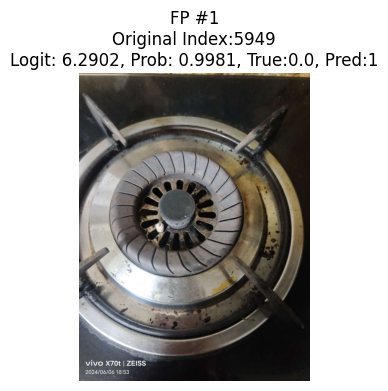

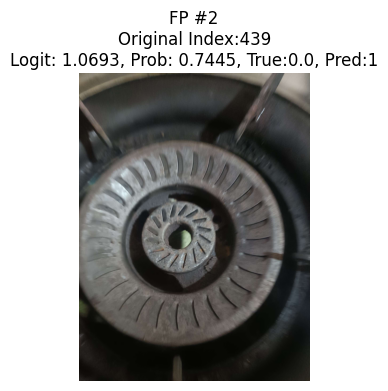

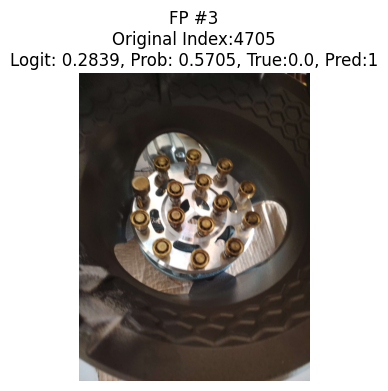

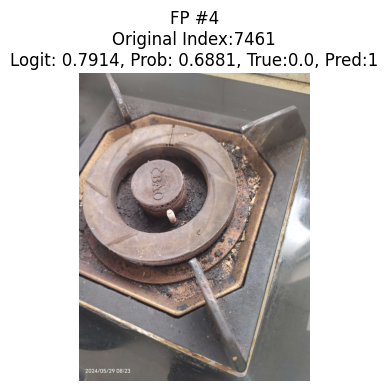

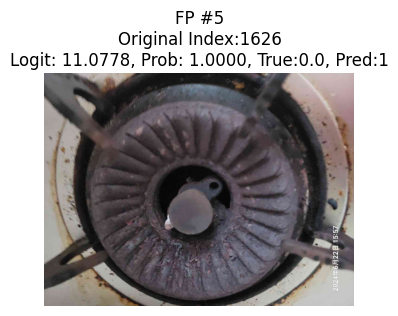

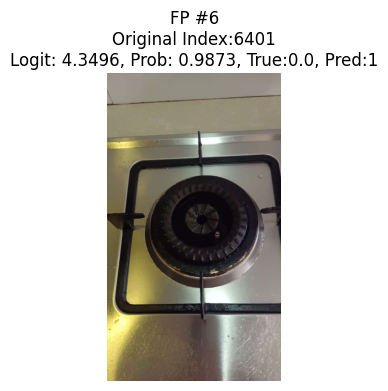

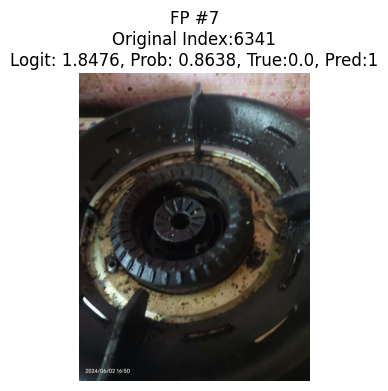

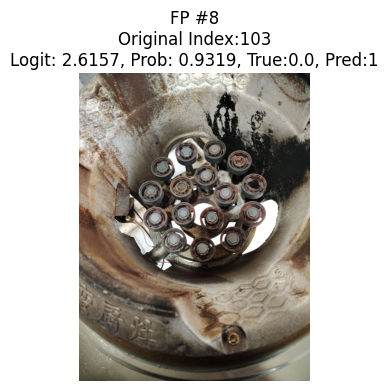

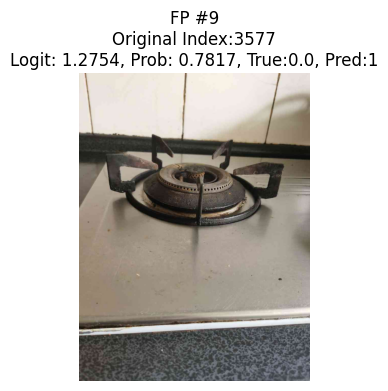

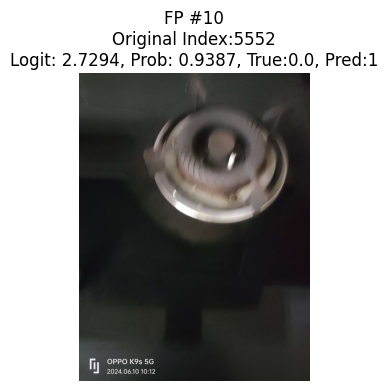

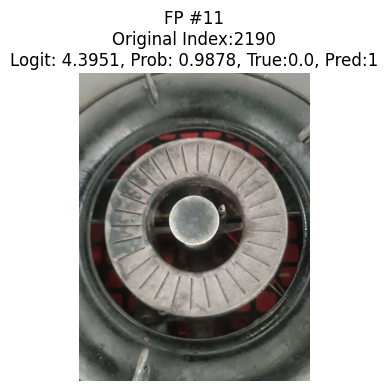

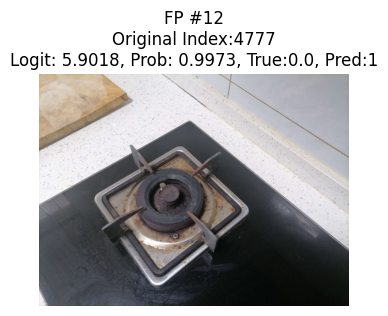

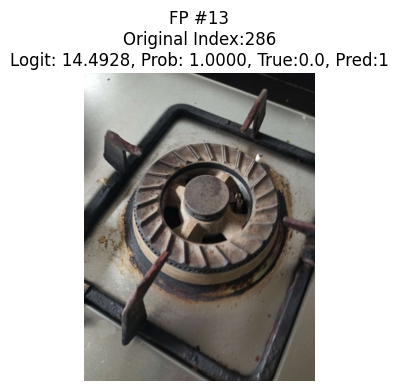

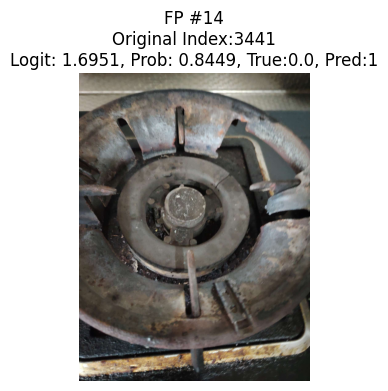

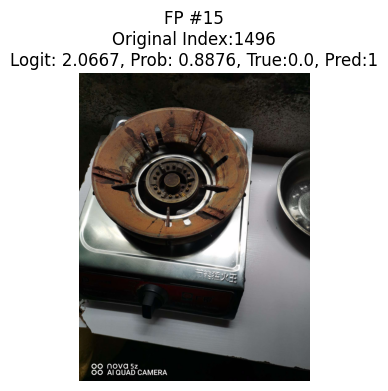

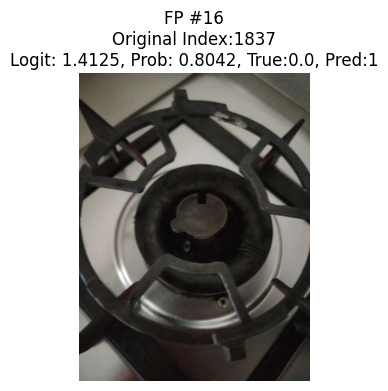

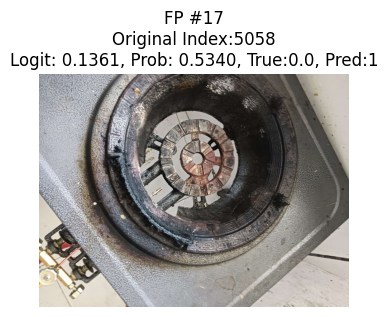

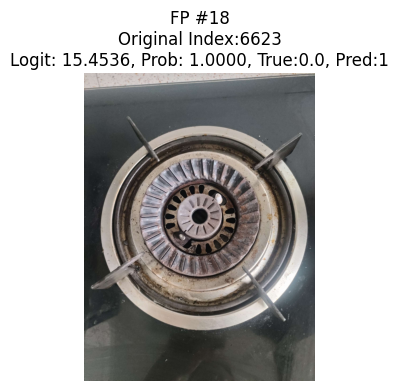

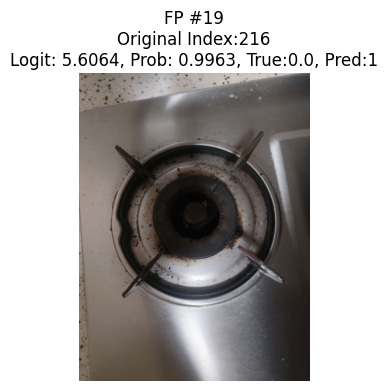

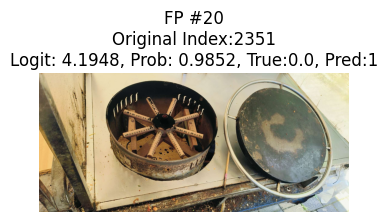

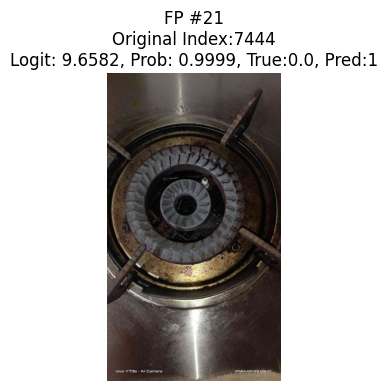

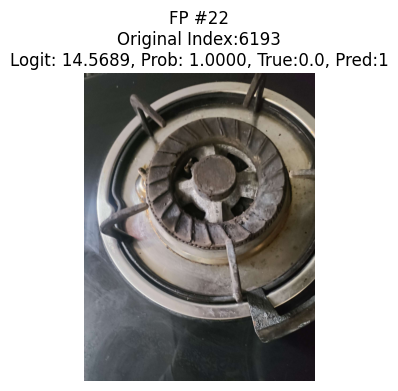

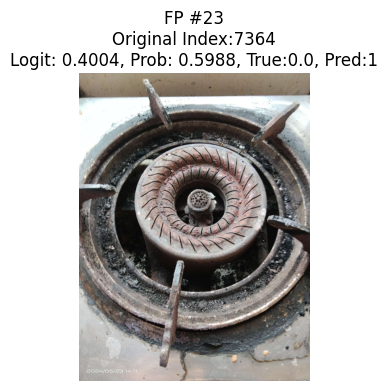

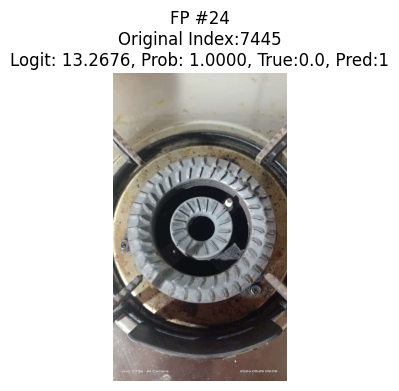

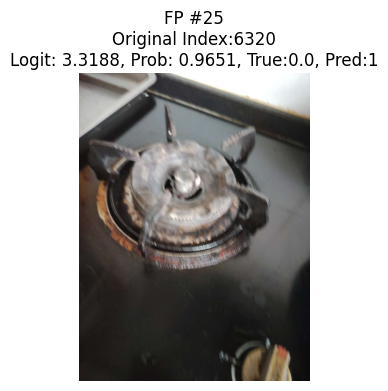

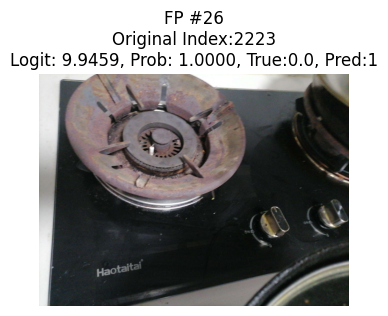

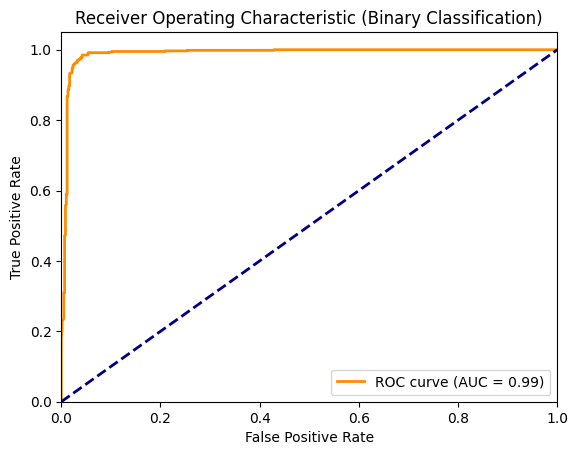

In [17]:
evaluate_model(model, test_loader, compute_metrics, device, image_save_dir)


In [18]:


def create_dataloaders(df, image_save_dir, transform, batch_size=16, num_workers=0):
    """
    划分数据集并创建DataLoader。
    
    Args:
        df (pd.DataFrame): 数据集DataFrame。
        image_save_dir (str): 图像保存目录路径。
        transform (callable): 图像转换函数。
        batch_size (int, optional): 批次大小。
        num_workers (int, optional): DataLoader的工作线程数。
    
    Returns:
        tuple: 训练集、验证集和测试集的DataLoader。
    """
    print("[INFO] Starting to create DataLoaders...")
    # 划分数据集

    # 创建数据集
    all_dataset = GasStoveDataset(df, image_save_dir, transform=transform, debug=True)
    
    # 创建数据加载器
    all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
   

    print("[INFO] DataLoaders created successfully.")
    return all_loader

all_loader = create_dataloaders(
    df_balanced, 
    image_save_dir, 
    transform, 
    batch_size=16, 
    num_workers=0
)


[INFO] Starting to create DataLoaders...
[INFO] DataLoaders created successfully.


In [ ]:

def evaluate_model(model, test_loader, compute_metrics_fn, device, image_save_dir):
    """
    Evaluate the model on the test set, compute performance metrics, 
    analyze false positives, and display their images.
    """
    print("[INFO] Starting evaluation on test set...")
    model.eval()
    test_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}
    conf_matrix = None

    all_labels = []
    all_scores = []
    
    # 用于存储预测详情的列表，包括logit、概率、真实标签、预测标签、以及数据集索引
    sample_details = []
    
    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        dataset = test_loader.dataset
        for batch_idx, (images, label_1, label_2) in enumerate(test_loop):
            images = images.to(device)
            label_1 = label_1.to(device).unsqueeze(1)
            label_2 = label_2.to(device)

            batch_size = images.size(0)
            start_idx = batch_idx * test_loader.batch_size
            end_idx = start_idx + batch_size

            logits_1, output_1, output_2 = model(images)

            precision, recall, f1, accuracy = compute_metrics_fn(output_1, label_1)
            test_metrics["precision"].append(precision)
            test_metrics["recall"].append(recall)
            test_metrics["f1"].append(f1)
            test_metrics["accuracy"].append(accuracy)

            logits_np = logits_1.cpu().numpy().flatten()
            probs_np = output_1.cpu().numpy().flatten()
            labels_np = label_1.cpu().numpy().flatten()
            preds_np = (probs_np > 0.9).astype(int)

            all_scores.extend(probs_np.tolist())
            all_labels.extend(labels_np.tolist())

            if conf_matrix is None:
                conf_matrix = confusion_matrix(labels_np, preds_np)
            else:
                conf_matrix += confusion_matrix(labels_np, preds_np)

            # 保存当前batch每个样本的详细信息
            for i in range(batch_size):
                df_idx = start_idx + i
                original_idx = dataset.df.iloc[df_idx]['original_index']
                sample_details.append({
                    'original_index': original_idx,
                    'logit': logits_np[i],
                    'prob': probs_np[i],
                    'true_label': labels_np[i],
                    'pred_label': preds_np[i]
                })

    # 计算平均指标
    avg_test_metrics = {k: sum(v)/len(v) for k, v in test_metrics.items()}
    print("\n[Test Results]")
    print(f"Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Recall: {avg_test_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_test_metrics['f1']:.4f}")
    print(f"Accuracy: {avg_test_metrics['accuracy']:.4f}")

    # 打印混淆矩阵
    print("Confusion Matrix:")
    print(conf_matrix)
    print("[INFO] Evaluation on test set completed.")

    # 假阳性分析：True Label=0(不合格), Pred Label=1(合格)
    false_positives = [s for s in sample_details if s['true_label'] == 0 and s['pred_label'] == 1]

    print("\n[False Positives Analysis]")
    print(f"Number of False Positives: {len(false_positives)}")
    
    # 显示假阳性样本的图片
    # 如果假阳性样本很多，可以限制显示的数量，例如只显示前10个
 # Assuming all other imports and variable definitions are done
    num_to_show = len(false_positives)

    for idx, fp in enumerate(false_positives[:num_to_show]):
        img_path = os.path.join(image_save_dir, f"image_{fp['original_index']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(
                f"FP #{idx+1}\nOriginal Index:{fp['original_index']}\n"
                f"Logit: {fp['logit']:.4f}, Prob: {fp['prob']:.4f}, "
                f"True:{fp['true_label']}, Pred:{fp['pred_label']}"
            )
            plt.axis('off')
            
            # Save after setting image and title
            os.makedirs("all_imgs", exist_ok=True)
            plt.savefig(f"imgs/fp_{idx+1}.png", dpi=300)
            plt.show()
        else:
            print(f"[WARNING] Image not found: {img_path}")

    # 计算并绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
evaluate_model(model, all_loader, compute_metrics, device, image_save_dir)


[INFO] Starting evaluation on test set...


Testing:   8%|▊         | 56/743 [00:24<04:50,  2.36it/s]

[DEBUG] Index 2: 不合格, 原因: 无熄火保护装置, label_2 set to 1


Testing:  22%|██▏       | 162/743 [01:08<04:30,  2.14it/s]

[DEBUG] Index 4: 不合格, 原因: 被挡住无法看出, label_2 set to 0


Testing:  24%|██▎       | 176/743 [01:14<03:58,  2.38it/s]

[DEBUG] Index 3: 不合格, 原因: 无熄火保护装置, label_2 set to 1


Testing:  47%|████▋     | 348/743 [02:23<02:41,  2.45it/s]